In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from google.colab import drive
from torch import nn
import os

from torchvision.models import resnet18, ResNet18_Weights
import torchvision
from tqdm import tqdm
from torchvision import transforms
from xgboost import XGBClassifier

ccvv

In [2]:
def plot_decision_boundaries(model, X, y, title='Decision Boundaries',
                             implicit_repr=False):
    """
    Plots decision boundaries of a classifier and colors the space by the prediction of each point.

    Parameters:
    - model: The trained classifier (sklearn model).
    - X: Numpy Feature matrix.
    - y: Numpy array of Labels.
    - title: Title for the plot.
    """
    # h = .02  # Step size in the mesh

    # enumerate y
    y_map = {v: i for i, v in enumerate(np.unique(y))}
    enum_y = np.array([y_map[v] for v in y]).astype(int)

    h_x = (np.max(X[:, 0]) - np.min(X[:, 0])) / 200
    h_y = (np.max(X[:, 1]) - np.min(X[:, 1])) / 200

    # Plot the decision boundary.
    added_margin_x = h_x * 20
    added_margin_y = h_y * 20
    x_min, x_max = X[:, 0].min() - added_margin_x, X[:,
                                                   0].max() + added_margin_x
    y_min, y_max = X[:, 1].min() - added_margin_y, X[:,
                                                   1].max() + added_margin_y
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h_x),
                         np.arange(y_min, y_max, h_y))

    # Make predictions on the meshgrid points.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    if implicit_repr:
        model_inp = np.c_[xx.ravel(), yy.ravel()]
        new_model_inp = np.zeros((model_inp.shape[0], model_inp.shape[1] * 10))
        alphas = np.arange(0.1, 1.05, 0.1)
        for i in range(model_inp.shape[1]):
            for j, a in enumerate(alphas):
                new_model_inp[:, i * len(alphas) + j] = np.sin(
                    a * model_inp[:, i])
        model_inp = torch.tensor(new_model_inp, dtype=torch.float32,
                                 device=device)
    else:
        model_inp = torch.tensor(np.c_[xx.ravel(), yy.ravel()],
                                 dtype=torch.float32, device=device)
    with torch.no_grad():
        Z = model(model_inp).argmax(dim=1).cpu().numpy()
    Z = np.array([y_map[v] for v in Z])
    Z = Z.reshape(xx.shape)
    vmin = np.min([np.min(enum_y), np.min(Z)])
    vmax = np.min([np.max(enum_y), np.max(Z)])

    # Plot the decision boundary.
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8, vmin=vmin,
                 vmax=vmax)

    # Scatter plot of the data points with matching colors.
    plt.scatter(X[:, 0], X[:, 1], c=enum_y, cmap=plt.cm.Paired, edgecolors='k',
                s=40, alpha=0.7, vmin=vmin, vmax=vmax)

    plt.title("Decision Boundaries")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(title)
    plt.show()

In [3]:
def read_data(filename):
    """
    Read the data from the csv file and return the features and labels as numpy arrays.
    """

    # the data in pandas dataframe format
    df = pd.read_csv(filename)

    # extract the column names
    col_names = list(df.columns)

    # the data in numpy array format
    features = df[['long','lat']].values

    labels = None

    if (len(col_names) != 2):
        labels = df['country'].values

    return features, labels

def chart_data(data ,row_headers, column_headers):
    df = pd.DataFrame(data, index=row_headers, columns=column_headers  )
    return df


# **7.2 Task**

In [ ]:

def get_loaders(path, transform, batch_size):
    """
    Get the data loaders for the train, validation and test sets.
    :param path: The path to the 'whichfaceisreal' directory.
    :param transform: The transform to apply to the images.
    :param batch_size: The batch size.
    :return: The train, validation and test data loaders.
    """
    train_set = torchvision.datasets.ImageFolder(root=os.path.join(path, 'train'), transform=transform)
    val_set = torchvision.datasets.ImageFolder(root=os.path.join(path, 'val'), transform=transform)
    test_set = torchvision.datasets.ImageFolder(root=os.path.join(path, 'test'), transform=transform)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Set the random seed for reproducibility
np.random.seed(42)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.CenterCrop(64), transforms.ToTensor()])
batch_size = 32
path = '/content/drive/MyDrive/Colab Notebooks/whichfaceisreal' # For example '/cs/usr/username/whichfaceisreal/'
train_loader, val_loader, test_loader = get_loaders(path, transform, batch_size)


# DATA LOADING
### DO NOT CHANGE THE CODE BELOW THIS LINE ###
train_data = []
train_labels = []
test_data = []
test_labels = []
with torch.no_grad():
    for (imgs, labels) in tqdm(train_loader, total=len(train_loader), desc='Train'):
        train_data.append(imgs)
        train_labels.append(labels)
    train_data = torch.cat(train_data, 0).cpu().numpy().reshape(len(train_loader.dataset), -1)
    train_labels = torch.cat(train_labels, 0).cpu().numpy()
    for (imgs, labels) in tqdm(test_loader, total=len(test_loader), desc='Test'):
        test_data.append(imgs)
        test_labels.append(labels)
    test_data = torch.cat(test_data, 0).cpu().numpy().reshape(len(test_loader.dataset), -1)
    test_labels = torch.cat(test_labels, 0).cpu().numpy()
### DO NOT CHANGE THE CODE ABOVE THIS LINE ###


### YOUR XGBOOST CODE GOES HERE ###
    learning_rate = [0.00001, 0.0001, 0.001, 0.01, 0.1]

    for l_rate in learning_rate:
        # Create an XGBoost classifier with the specified learning rate
        xgb = XGBClassifier(learning_rate=l_rate)

        # Train the classifier
        xgb.fit(train_data, train_labels)

        # Compute the accuracy of the classifier on the test set
        accuracy = xgb.score(test_data, test_labels)

        print(f'XGBClassifier with Learning Rate {l_rate:.5f} - Accuracy: {accuracy:.4f}')





Test: 100%|██████████| 13/13 [00:20<00:00,  1.59s/it]


XGBClassifier with Learning Rate 0.00001 - Accuracy: 0.6300
XGBClassifier with Learning Rate 0.00010 - Accuracy: 0.6300
XGBClassifier with Learning Rate 0.00100 - Accuracy: 0.6525
XGBClassifier with Learning Rate 0.01000 - Accuracy: 0.7100
XGBClassifier with Learning Rate 0.10000 - Accuracy: 0.7375


1. XGBoost: Use the XGBoost classifier with default parameters.

In [ ]:
# def Q_7_1():
#     """XGBoost: Use the XGBoost classifier with default parameters."""
#     # Create an XGBoost classifier
#     xgb = XGBClassifier()

#     # Train the classifier
#     xgb.fit(train_data, train_labels)

#     # Compute the accuracy of the classifier on the test set
#     accuracy = xgb.score(test_data, test_labels)

#     print(f'XGBClassifier Accuracy: {accuracy:.4f}')
#     return accuracy

# Q_7_1()

Training from Scratch: Train a ResNet18 classifier on the training data. The output layer will have a dimension of 1, implementing logistic regression. All the ResNet18 weights will be trained from scratch in this part.

In [4]:
class ResNet18(nn.Module):
    def __init__(self, pretrained=False, probing=False):
        super(ResNet18, self).__init__()
        if pretrained:
            weights = ResNet18_Weights.IMAGENET1K_V1
            self.transform = ResNet18_Weights.IMAGENET1K_V1.transforms()
            self.resnet18 = resnet18(weights=weights)
        else:
            self.transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
            self.resnet18 = resnet18()

        in_features_dim = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Identity()

        if probing:
            for name, param in self.resnet18.named_parameters():
                param.requires_grad = False
        self.logistic_regression = nn.Linear(in_features_dim, 1)

    def forward(self, x):

        # Forward pass the input through the ResNet18
        features = self.resnet18(x)
        # Flatten the features to pass them to the logistic regression
        features = torch.flatten(features, 1)
        # return the output of the logistic regression
        return self.logistic_regression(features)

In [5]:
def get_loaders(path, transform, batch_size):
    """
    Get the data loaders for the train, validation and test sets.
    :param path: The path to the 'whichfaceisreal' directory.
    :param transform: The transform to apply to the images.
    :param batch_size: The batch size.
    :return: The train, validation and test data loaders.
    """
    train_set = torchvision.datasets.ImageFolder(root=os.path.join(path, 'train'), transform=transform)
    val_set = torchvision.datasets.ImageFolder(root=os.path.join(path, 'val'), transform=transform)
    test_set = torchvision.datasets.ImageFolder(root=os.path.join(path, 'test'), transform=transform)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader


def compute_accuracy(model, data_loader, device):
    """
    Compute the accuracy of the model on the data in data_loader
    :param model: The model to evaluate.
    :param data_loader: The data loader.
    :param device: The device to run the evaluation on.
    :return: The accuracy of the model on the data in data_loader
    """
    model.eval()
    correct = 0
    total = 0
    # Iterate over the data in the data loader
    with torch.no_grad():
        for inputs, labels in data_loader:
            # Move the inputs and labels to the device
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            outputs = model(inputs)
            # Compute the accuracy
            predicted = torch.round(torch.sigmoid(outputs))
            correct += (predicted == labels.view(-1, 1)).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    return accuracy



def run_training_epoch(model, criterion, optimizer, train_loader, device):
    """
    Run a single training epoch
    :param model: The model to train
    :param criterion: The loss function
    :param optimizer: The optimizer
    :param train_loader: The data loader
    :param device: The device to run the training on
    :return: The average loss for the epoch.
    """
    model.train()
    # compute the average loss for the epoch

    # Initialize the total loss
    total_loss = 0


    # Iterate over the data
    for (imgs, labels) in tqdm(train_loader, total=len(train_loader)):

        batch_size = imgs.size(0)

        # Move the data to the device
        imgs, labels = imgs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass the input through the model
        outputs = model(imgs)

        # Compute the loss
        loss = criterion(outputs, labels.float().view(-1, 1))

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Add the loss to the total loss
        total_loss += loss.item() * batch_size



    # Compute the average loss
    avg_loss = total_loss / len(train_loader.dataset)

    # Return the average loss
    return avg_loss




In [6]:
def from_scratch(learning_rate, batch_size  , num_of_epochs  ):



    # loop over the learning rates
    for l_rate in learning_rate:
        print(l_rate)

        # initialize the model from scratch
        model = ResNet18(pretrained=False, probing=False)

        # get the transform to apply to the images
        transform = model.transform

        path = '/content/drive/MyDrive/Colab Notebooks/whichfaceisreal'
        train_loader, val_loader, test_loader = get_loaders(path, transform, batch_size)

        # move the model to the device
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)

        ### Define the loss function and the optimizer
        criterion = torch.nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=l_rate)

        # Train the model
        for epoch in range(num_of_epochs):

            # Run a training epoch
            loss = run_training_epoch(model, criterion, optimizer, train_loader, device)

            # Compute the accuracy
            train_acc = compute_accuracy(model, train_loader, device)

            # Compute the validation accuracy
            val_acc = compute_accuracy(model, val_loader, device)
            test_acc = compute_accuracy(model, test_loader, device)

            print(f'Learning rate: {l_rate:.6f}, Loss: {loss:.6f}, Train accuracy: {train_acc:.6f}, Val accuracy: {val_acc:.6f}, Test accuracy: {test_acc:.6f}')



In [7]:

def linear_probing(learning_rate  , batch_size  , num_of_epochs  ):
    """Train a frozen ResNet18 model pretrained on ImageNet classification.
      We’ll add a final linear layer on top of this frozen backbone,
        projecting the data into a size 1 dimension. Only this final layer will be optimized."""

    # Set the random seed for reproducibility
    torch.manual_seed(42)

    for l_rate in learning_rate:
        print(l_rate)


        # initialize the model of Linear probing
        model = ResNet18(pretrained=True, probing=True)
        transform = model.transform

        path = '/content/drive/MyDrive/Colab Notebooks/whichfaceisreal'
        train_loader, val_loader, test_loader = get_loaders(path, transform, batch_size)

        # move the model to the device
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)

        ### Define the loss function and the optimizer
        criterion = torch.nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=l_rate)


        ### Train the model
        # Train the model
        for epoch in range(num_of_epochs):
            # Run a training epoch
            loss = run_training_epoch(model, criterion, optimizer, train_loader, device)

            # Compute the accuracy
            train_acc = compute_accuracy(model, train_loader, device)

            # Compute the validation accuracy
            val_acc = compute_accuracy(model, val_loader, device)

            # Compute the test accuracy
            test_acc = compute_accuracy(model, test_loader, device)

            print(f'Learning rate: {l_rate:.6f}, Loss: {loss:.6f}, Train accuracy: {train_acc:.6f}, Val accuracy: {val_acc:.6f}, Test accuracy: {test_acc:.6f}')


In [8]:
def fine_tuning(learning_rate , batch_size  , num_of_epochs ):
    """"Fine-tuning: Fine-tune a ResNet18 model pretrained on ImageNet clas- sification. Similar to the linear probing approach,
    we’ll add a final linear layer for binary classification. However,
      in this case, we will optimize the entire pretrained model."""

    # Set the random seed for reproducibility
    torch.manual_seed(42)

    for l_rate in learning_rate:

            print(l_rate)

            # initialize the model of Linear probing
            model = ResNet18(pretrained=True, probing=False)
            transform = model.transform

            path = '/content/drive/MyDrive/Colab Notebooks/whichfaceisreal'
            train_loader, val_loader, test_loader = get_loaders(path, transform, batch_size)

            # move the model to the device
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            model = model.to(device)

            ### Define the loss function and the optimizer
            criterion = torch.nn.BCEWithLogitsLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=l_rate)

            # Train the model
            for epoch in range(num_of_epochs):
                # Run a training epoch
                loss = run_training_epoch(model, criterion, optimizer, train_loader, device)

                # Compute the accuracy
                train_acc = compute_accuracy(model, train_loader, device)

                # Compute the validation accuracy
                val_acc = compute_accuracy(model, val_loader, device)

                # Compute the test accuracy
                test_acc = compute_accuracy(model, test_loader, device)

                print(f'Learning rate: {l_rate:.6f}, Loss: {loss:.6f}, Train accuracy: {train_acc:.6f}, Val accuracy: {val_acc:.6f}, Test accuracy: {test_acc:.6f}')




In [9]:
def Q_7():
    """For this 3 (Training from Scratch , Linear Probing , Fine-tuning ), well experiment with the Adam optimizer and with different learning rates in the range of
    [0.00001, 0.1].
    The training will be conducted with a batch size of 32 samples for 1 epoch. The loss
    function of this task would be binary cross-entropy (you may find torch.nn.BCEWithLogitsLoss useful for this).
    For the XGBoost classifier, employ the xgboost library with default param- eters."""
    learning_rate = [0.00001, 0.0001, 0.001, 0.01, 0.1]
    batch_size = 32

    # From Scratch
    print("from_scratch")
    from_scratch(learning_rate , batch_size , 1 )

    print("linear_probing")

    linear_probing(learning_rate , batch_size , 1 )


    print("fine_tuning")

    fine_tuning(learning_rate , batch_size , 1 )




Q_7()

from_scratch
1e-05


100%|██████████| 44/44 [04:46<00:00,  6.52s/it]


KeyboardInterrupt: 

In [20]:
def imshow(image, title):
    # Assuming image is a PyTorch tensor
    image = image.permute(1, 2, 0).numpy()  # Change the order of dimensions for Matplotlib
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')  # Turn off the x and y axis lines

    plt.show()


In [36]:
def visualize_misclassified_samples(best_model, worst_model, test_loader, device, num_samples=5):
    best_correct_predictions = []
    worst_misclassified_predictions = []
    true_labels = []

    # Set models to evaluation mode
    best_model.eval()
    worst_model.eval()

    with torch.no_grad():
        for inputs, labels in test_loader:

            # Move the data to the device
            inputs, labels = inputs.to(device), labels.to(device)
            best_outputs = torch.sigmoid(best_model(inputs))
            worst_outputs = torch.sigmoid(worst_model(inputs))

            # Round the predictions of the models on the test set
            best_predictions = torch.round(best_outputs)
            worst_predictions = torch.round(worst_outputs)

            # Find samples correctly classified by the best model and misclassified by the worst model
            # 1. Correctly classified by the best model
            correct_best = (best_predictions == labels.view(-1, 1)).squeeze()
            # 2. Misclassified by the worst model
            misclassified_worst = (worst_predictions != labels.view(-1, 1)).squeeze()

            # Find the samples that satisfy both conditions
            correct_best_misclassified_worst = correct_best & misclassified_worst

            # Append image tensors and true labels to the lists
            best_correct_predictions.extend(inputs[correct_best_misclassified_worst][:num_samples])
            # Append the misclassified images to the list
            worst_misclassified_predictions.extend(inputs[correct_best_misclassified_worst][:num_samples])
            true_labels.extend(labels[correct_best_misclassified_worst][:num_samples])

            # Break the loop if the required number of samples is found
            if len(best_correct_predictions) >= num_samples:
                break

    # Visualize the samples
    for i in range(num_samples):
        # Get the images and true labels
        best_img = best_correct_predictions[i].cpu()

        best_img_title = f"Best Model Correct and Worst model Worng Image: {i}"

        imshow(best_img, best_img_title)


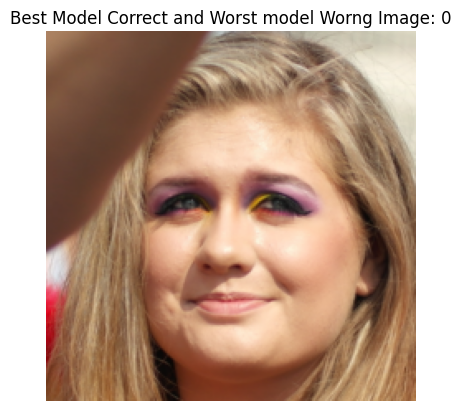

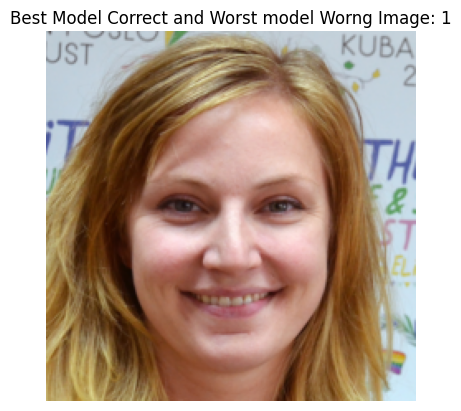

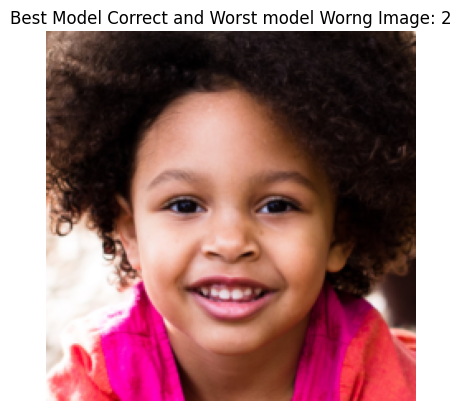

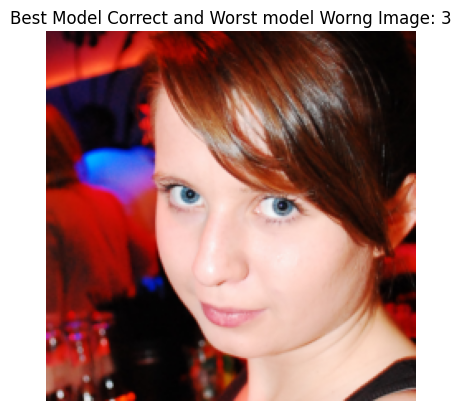

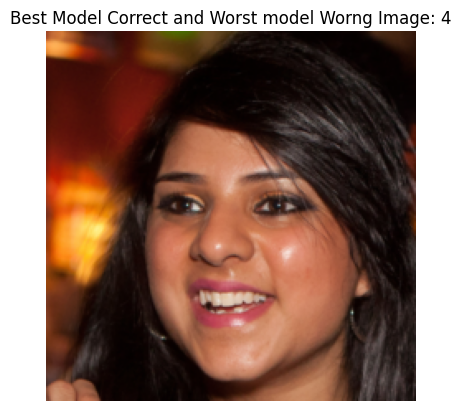

In [37]:
def Q_7_4_2():
    """Visualize 5 samples correctly classified by your best baseline but misclas- sified by your worst-performing baselines."""

    # init the best model - fine-tuning learning rate = 0.0001
    best_model = ResNet18(pretrained=True, probing=False)
    transform = best_model.transform
    batch_size = 32
    path = '/content/drive/MyDrive/Colab Notebooks/whichfaceisreal'

    best_train_loader, best_val_loader, best_test_loader = get_loaders(path, transform, batch_size)

    ## Define the loss function and the optimizer
    best_model_criterion = torch.nn.BCEWithLogitsLoss()
    best_model_optimizer = torch.optim.Adam(best_model.parameters(), lr=0.0001)
    # move the model to the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    best_model = best_model.to(device)

    # Train the model
    loss = run_training_epoch(best_model, best_model_criterion, best_model_optimizer, best_train_loader, device)

    # Compute the accuracy
    train_acc = compute_accuracy(best_model, best_train_loader, device)

    # Compute the validation accuracy
    val_acc = compute_accuracy(best_model, best_val_loader, device)

    # Compute the test accuracy
    test_acc = compute_accuracy(best_model, best_test_loader, device)

    print(f'best model - Loss: {loss:.4f}, Train accuracy: {train_acc:.4f}, Val accuracy: {val_acc:.4f}, Test accuracy: {test_acc:.4f}')

    # init the worst model - from scratch learning rate = 0.1
    worst_model = ResNet18(pretrained=False, probing=False)
    transform = worst_model.transform
    batch_size = 32
    worst_train_loader, worst_val_loader, worst_test_loader = get_loaders(path, transform, batch_size)

        # move the model to the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    worst_model = worst_model.to(device)


    ## Define the loss function and the optimizer
    worst_model_criterion = torch.nn.BCEWithLogitsLoss()
    worst_model_optimizer = torch.optim.Adam(worst_model.parameters(), lr=0.1)

    # Train the model
    loss = run_training_epoch(worst_model, worst_model_criterion, worst_model_optimizer, worst_train_loader, device)

    # Compute the accuracy
    train_acc = compute_accuracy(worst_model, worst_train_loader, device)

    # Compute the validation accuracy
    val_acc = compute_accuracy(worst_model, worst_val_loader, device)

    # Compute the test accuracy
    test_acc = compute_accuracy(worst_model, worst_test_loader, device)

    print(f'worst model - Loss: {loss:.4f}, Train accuracy: {train_acc:.4f}, Val accuracy: {val_acc:.4f}, Test accuracy: {test_acc:.4f}')

    train_loader, val_loader, test_loader = get_loaders(path, transform, batch_size)


    # find the images to Visualize
    visualize_misclassified_samples(best_model, worst_model, test_loader, device, num_samples=5)

Q_7_4_2()
